In [232]:
# Loading libraries
import random                        # Library to generate random numbers
import skimage                       # Library for image manipulation
import numpy as np                   # Library for array manipulation
import urllib.request                # Library to download data
import matplotlib.pyplot as plt      # Library used for plotting
from skimage import io, measure               # Module from skimage
from skimage.io import imread        # Module from skimage to read images as numpy arrays
from skimage.filters import gaussian # Module working with a gaussian filter
import pathlib                              # Library to work with file paths
import os
%matplotlib inline

from ipywidgets import interactive, HBox, VBox, Layout
import ipywidgets as widgets

from skimage.morphology import binary_dilation
from skimage.segmentation import watershed
from skimage.draw import polygon
from skimage.measure import regionprops
from skimage.color import label2rgb
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from skimage.morphology import binary_closing
from skimage.morphology import binary_opening
from skimage.morphology import disk
from skimage.morphology import remove_small_objects
from scipy import ndimage as ndi              # Distance Transform
from skimage.feature import peak_local_max    # Local maxima in a matrix
from skimage.segmentation import watershed    # Watershed algorithm
from skimage.filters import difference_of_gaussians

In [233]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


Here Pilar is working on the strategies for importing the image using techniques from Luis's tutorials. 

In [234]:
# Here Jakini will work on the intensity of transcription cites of each cell at different time frames. 

In [235]:
urls = ['https://github.com/MunskyGroup/UQbio2024_Team4/blob/main/Drug10_1000nM/rep1_FOV1.tif', 'https://github.com/MunskyGroup/UQbio2024_Team4/blob/main/Drug10_1000nM/rep1_FOV2.tif', 'https://github.com/MunskyGroup/UQbio2024_Team4/blob/main/Drug10_1000nM/rep1_FOV3.tif', 'https://github.com/MunskyGroup/UQbio2024_Team4/blob/main/Drug10_1000nM/rep1_FOV4.tif', 'https://github.com/MunskyGroup/UQbio2024_Team4/blob/main/Drug10_1000nM/rep1_FOV5.tif', 'https://github.com/MunskyGroup/UQbio2024_Team4/blob/main/Drug10_1000nM/rep1_FOV6.tif', 'https://github.com/MunskyGroup/UQbio2024_Team4/blob/main/Drug10_1000nM/rep2_FOV1.tif', 'https://github.com/MunskyGroup/UQbio2024_Team4/blob/main/Drug10_1000nM/rep2_FOV2.tif', 'https://github.com/MunskyGroup/UQbio2024_Team4/blob/main/Drug10_1000nM/rep2_FOV3.tif', 'https://github.com/MunskyGroup/UQbio2024_Team4/blob/main/Drug10_1000nM/rep2_FOV4.tif', 'https://github.com/MunskyGroup/UQbio2024_Team4/blob/main/Drug10_1000nM/rep2_FOV5.tif', 'https://github.com/MunskyGroup/UQbio2024_Team4/blob/main/Drug10_1000nM/rep2_FOV6.tif']

In [236]:
# Importing the image as variable img
figName = 'Drug1_1000nM/rep1_FOV1.tif'
img = imread(str(figName))
type(img)

numpy.ndarray

In [237]:
np.shape(img)

(21, 650, 650, 3)

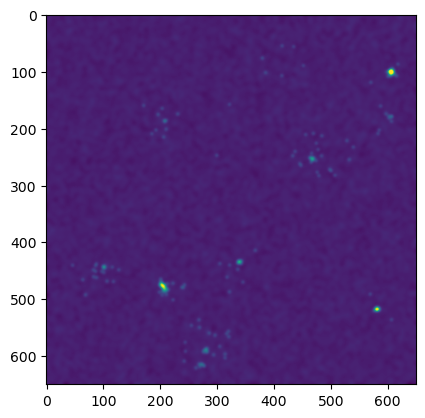

In [238]:
plt.imshow(img[1,:,:,2])
# plt.imshow(img[1,:,:,1]alpha=.3)
plt.imshow(img[1,:,:,2])

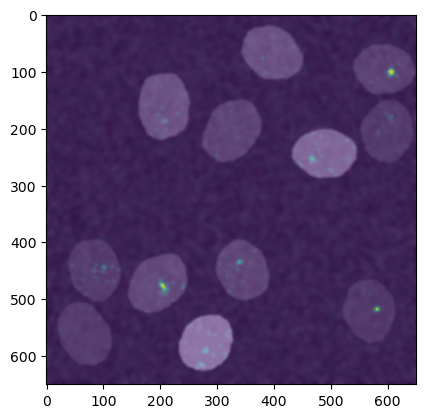

In [239]:
plt.imshow(img[1,:,:,1], cmap='Greys_r')
plt.imshow(img[1,:,:,2], alpha=.6)

/var/folders/39/0c19qs6j0k3gkl1c71w87ghr0000gn/T/ipykernel_103/3723408758.py:23: RuntimeWarning: divide by zero encountered in log10
  ax[1,1].plot(survival, np.log10(np.arange(len(survival))))


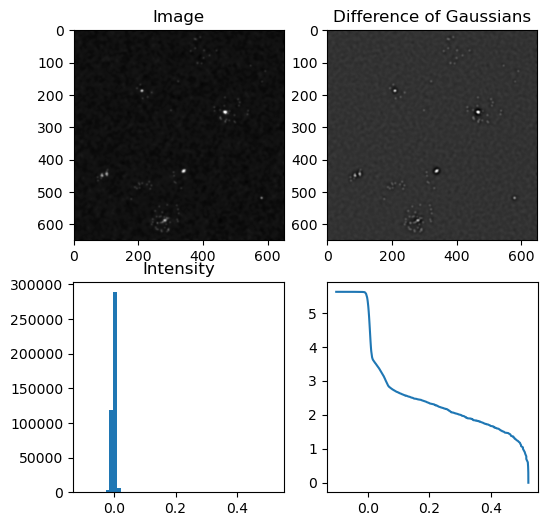

intensity range:  -0.10279021191003723 0.5222816896072586


In [240]:
# Selecting the color channel with RNA spots
zSlice = 0
iChannel = 2
img_spots = img[zSlice,:,:,iChannel]

# Show the original image
fig, ax = plt.subplots(2,2, figsize=(6, 6))
ax[0,0].imshow(img_spots,cmap='Greys_r')
ax[0,0].set(title='Image')

# Apply a difference of Gaussians filter to the image to enhance spots
img_spots_filtered = difference_of_gaussians(img_spots,low_sigma=1, high_sigma=5)
ax[0,1].imshow(img_spots_filtered,cmap='Greys_r')
ax[0,1].set(title= 'Difference of Gaussians' )

# Make a histogram of the intensity values
ax[1,0].hist(img_spots_filtered.flatten(),bins=50)
ax[1,0].set(title= 'Intensity' )

# Make a survival plot of the intensity values
survival = np.sort(img_spots_filtered.flatten())
survival = survival[::-1]
ax[1,1].plot(survival, np.log10(np.arange(len(survival))))

plt.show()
print('intensity range: ', np.min(img_spots_filtered), np.max(img_spots_filtered))

In [241]:
threshold = 0.06

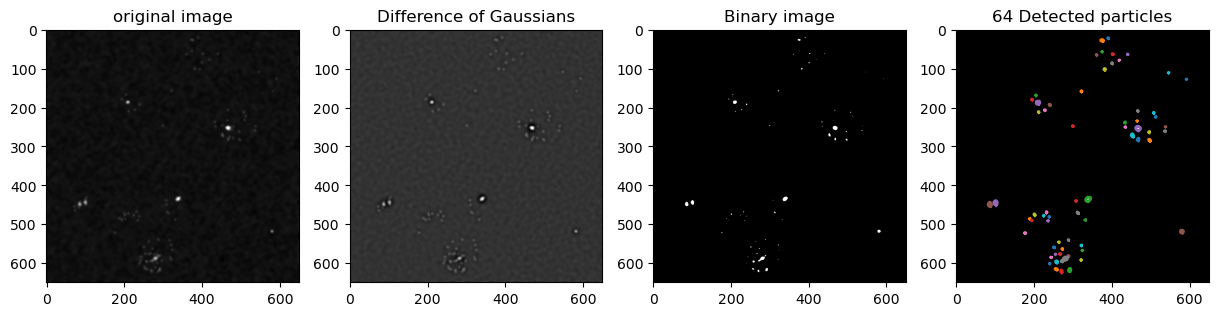

In [242]:
# Show original image in MS2 channel 
fig, ax = plt.subplots(1,4, figsize=(15, 6)) 
ax[0].imshow(img_spots,cmap='Greys_r')
ax[0].set(title='original image')

# Apply a difference of Gaussians filter to the image to enhance spots
ax[1].imshow(img_spots_filtered,cmap='Greys_r')
ax[1].set(title= 'Difference of Gaussians' )

# Apply a Threshold to the image to create binary image
img_spots_binary = img_spots_filtered.copy()
img_spots_binary[img_spots_binary>=threshold] = threshold # Making spots above the threshold equal to the threshold value.
img_spots_binary[img_spots_binary<threshold] = 0 # Making spots below the threshold equal to 0.
ax[2].imshow(img_spots_binary,cmap='Greys_r')
ax[2].set(title= 'Binary image' )

# Image binarization
img_spots_binary[img_spots_binary!=0] = 1 # Binarization
ax[3].imshow(img_spots_binary, cmap=plt.cm.gray)

# Labeling. Joining pixels in "particles"
spot_contours = measure.find_contours(img_spots_binary, 0.5)
for contour in spot_contours:
    ax[3].plot(contour[:, 1], contour[:, 0], linewidth=2)
ax[3].set(title= str(len(spot_contours))+' Detected particles' )
plt.show()

In [246]:
# Counting the detected particles in each cell

# Load the masks for the nucleus and cytosol
figName = 'Drug1_1000nM_masks/rep1_FOV1_masks.tif'
nucleus_mask = imread(str(figName))

number_detected_cells = np.max(nucleus_mask)

list_cytosol_particles = np.zeros(number_detected_cells)
list_nuclear_particles = np.zeros(number_detected_cells)

# Loop through the cytosol masks
for i in range(len(spot_contours)):
    # Find the position of the particle
    posn = np.mean(spot_contours[i], axis=0).astype(int)

    # Check which cyto mask is the particle in
    cell_num = masks_cyto[posn[0], posn[1]]
    if cell_num>0:
        list_cytosol_particles[cell_num-1] += 1

        # Check if the particle is also in the nucleus
        if nucleus_mask[posn[0], posn[1]] == nucleus_indices[cell_num]:
            list_nuclear_particles[cell_num-1] += 1

# Add the number of particles to the dataframe
df['Particles in cytosol'] = list_cytosol_particles
df['Particles in nucleus'] = list_nuclear_particles

FileNotFoundError: [Errno 2] No such file or directory: '/Users/pilarameijeiras/Documents/GitHub/UQbio2024_Team4/Drug1_1000nM_masks/rep1_FOV1_masks.tif'